In [71]:
%config Completer.use_jedi = False

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
import sklearn
import rdkit
import matplotlib
import xgboost


In [73]:
print(sklearn.__version__)
print(pd.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(rdkit.__version__)
print(xgboost.__version__)


1.6.1
2.2.2
2.2.3
3.9.3
2024.09.3
3.0.2


# Load and prepare data

In [23]:
fd_props = pd.read_csv('../data/filtered_template_based_docking_w_descriptors.csv')
fd_props = fd_props.dropna().reset_index(drop=True)
for i, rmsd in  fd_props[['rmsd']].itertuples():
    if rmsd >= 2:
        fd_props.at[i, 'label'] = 1
    else:
        fd_props.at[i, 'label'] = 0
        
fd_props.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19664 entries, 0 to 19663
Data columns (total 55 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   UniProt_ID                         19664 non-null  object 
 1   Template                           19664 non-null  object 
 2   Ligand_ID                          19664 non-null  object 
 3   Pose_ID                            19664 non-null  int64  
 4   rmsd                               19664 non-null  float64
 5   MCS                                19664 non-null  object 
 6   Template_Total_SASA                19664 non-null  float64
 7   Template_Polar_SASA                19664 non-null  float64
 8   Template_Apolar_SASA               19664 non-null  float64
 9   Docked_Total_SASA                  19664 non-null  float64
 10  Docked_Polar_SASA                  19664 non-null  float64
 11  Docked_Apolar_SASA                 19664 non-null  flo

In [6]:
feature_cols = [
    "Template_Total_SASA",
    "Template_Polar_SASA",
    "Template_Apolar_SASA",
    "Docked_Total_SASA",
    "Docked_Polar_SASA",
    "Docked_Apolar_SASA",
    "Template_HeavyAtomCount",
    "Template_NHOHCount",
    "Template_NOCount",
    "Template_NumHAcceptors",
    "Template_NumHDonors",
    "Template_NumHeteroAtoms",
    "Template_NumRotatableBonds",
    "Template_RingSystemsCount",
    "Template_RingCount",
    "Template_NumAliphaticRings",
    "Template_NumAromaticRings",
    "Template_NumAliphaticHeterocycles",
    "Template_NumAromaticHeterocycles",
    "Docked_HeavyAtomCount",
    "Docked_NHOHCount",
    "Docked_NOCount",
    "Docked_NumHAcceptors",
    "Docked_NumHDonors",
    "Docked_NumHeteroAtoms",
    "Docked_NumRotatableBonds",
    "Docked_RingSystemsCount",
    "Docked_RingCount",
    "Docked_NumAliphaticRings",
    "Docked_NumAromaticRings",
    "Docked_NumAliphaticHeterocycles",
    "Docked_NumAromaticHeterocycles",
    "Template_MCS_HeavyAtomRatio",
    "Template_MCS_NHOH_Atoms",
    "Template_MCS_NO_Atoms",
    "Template_MCS_H_Acceptors",
    "Template_MCS_H_Donors",
    "Docked_MCS_HeavyAtomRatio",
    "Docked_MCS_NHOH_Atoms",
    "Docked_MCS_NO_Atoms",
    "Docked_MCS_H_Acceptors",
    "Docked_MCS_H_Donors",
    "ECTS_H_Donors",
    "FCTS_H_Donors",
    "MCS_SMARTS_Atoms_wildcards",
    "MCS_SMARTS_Bonds_wildcards"
                ]

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, make_scorer, f1_score

# Define your features and target
X = fd_props[feature_cols]
y = fd_props['label']  # Replace 'Label' with your actual target column name

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(X_test)
print("Dummy Classifier Report:\n", classification_report(y_test, y_dummy_pred))

# Baseline 2: Basic Logistic Regression (no class_weight, no tuning)
baseline_logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
baseline_logreg.fit(X_train, y_train)
y_baseline_pred = baseline_logreg.predict(X_test)
print("Baseline Logistic Regression Report:\n", classification_report(y_test, y_baseline_pred))



/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Dummy Classifier Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1615
         1.0       0.59      1.00      0.74      2318

    accuracy                           0.59      3933
   macro avg       0.29      0.50      0.37      3933
weighted avg       0.35      0.59      0.44      3933

Baseline Logistic Regression Report:
               precision    recall  f1-score   support

         0.0       0.65      0.48      0.55      1615
         1.0       0.69      0.82      0.75      2318

    accuracy                           0.68      3933
   macro avg       0.67      0.65      0.65      3933
weighted avg       0.68      0.68      0.67      3933



In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred)  # get results as dict
print(report)

              precision    recall  f1-score   support

         0.0       0.69      0.82      0.75      2316
         1.0       0.65      0.48      0.55      1617

    accuracy                           0.68      3933
   macro avg       0.67      0.65      0.65      3933
weighted avg       0.68      0.68      0.67      3933



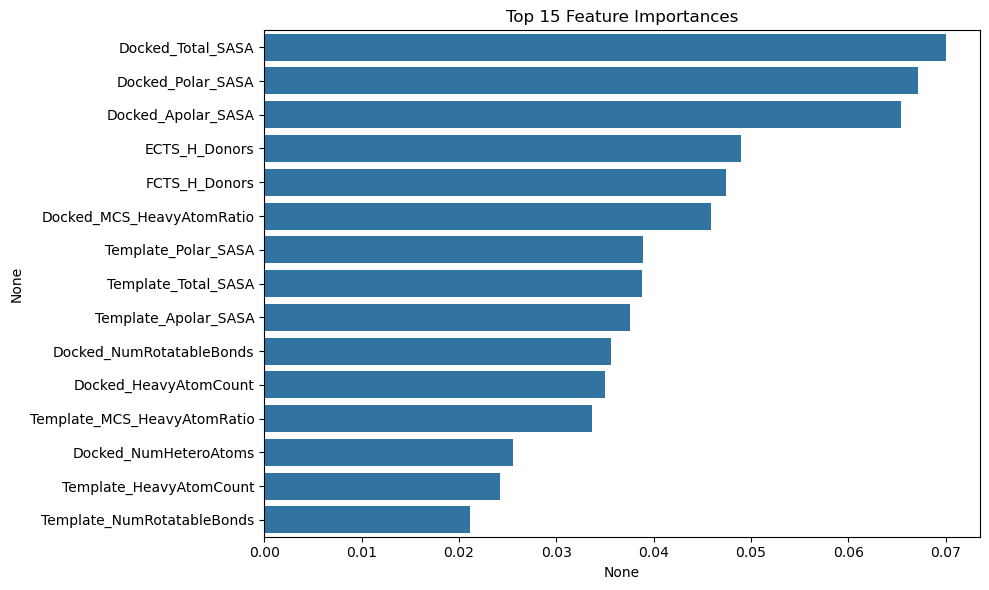

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot feature importances
importances = pd.Series(model.feature_importances_, index=feature_cols)
top_importances = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_importances.index)
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from xgboost import XGBClassifier


In [26]:
# Prepare data
X = fd_props[feature_cols]
y = fd_props['label']  # Change if your target column has another name

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models and parameter grids
models = {
    'LinearSVC': {
        'model': LinearSVC(random_state=42, max_iter=10000),
        'params': {
            'C': [0.01, 0.1, 1, 10]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=10000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],  # can add 'l1' if solver supports it
            'solver': ['lbfgs']
        }
    },
    'KNeighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['minkowski', 'euclidean']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1],
            'colsample_bytree': [0.8, 1]
        }
    }    

#     'SVC': {
#         'model': SVC(random_state=42),
#         'params': {
#             'C': [0.1, 1, 10],
#             'kernel': ['rbf', 'poly'],
#             'gamma': ['scale', 'auto']
#         }
#     }
}

best_models = {}
for name, mp in models.items():
    print(f"Running GridSearchCV for {name}...")
    gs = GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    print(f"Best params for {name}: {gs.best_params_}")
    print(f"Best CV score for {name}: {gs.best_score_:.4f}")
    
    # Save best estimator
    best_models[name] = gs.best_estimator_
    
    # Evaluate on test set
    y_pred = gs.best_estimator_.predict(X_test)
    print(f"Test classification report for {name}:\n{classification_report(y_test, y_pred)}\n")


Running GridSearchCV for LinearSVC...
Best params for LinearSVC: {'C': 0.1}
Best CV score for LinearSVC: 0.6785
Test classification report for LinearSVC:
              precision    recall  f1-score   support

         0.0       0.64      0.48      0.55      1615
         1.0       0.69      0.82      0.75      2318

    accuracy                           0.68      3933
   macro avg       0.67      0.65      0.65      3933
weighted avg       0.67      0.68      0.67      3933


Running GridSearchCV for RandomForest...
Best params for RandomForest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score for RandomForest: 0.7743
Test classification report for RandomForest:
              precision    recall  f1-score   support

         0.0       0.75      0.68      0.71      1615
         1.0       0.79      0.84      0.82      2318

    accuracy                           0.78      3933
   macro avg       0.77      0.76      0.77      3933
weighted avg       0.78     

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Best params for LogisticRegression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score for LogisticRegression: 0.6806
Test classification report for LogisticRegression:
              precision    recall  f1-score   support

         0.0       0.65      0.48      0.55      1615
         1.0       0.69      0.82      0.75      2318

    accuracy                           0.68      3933
   macro avg       0.67      0.65      0.65      3933
weighted avg       0.67      0.68      0.67      3933


Running GridSearchCV for KNeighbors...
Best params for KNeighbors: {'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'distance'}
Best CV score for KNeighbors: 0.6776
Test classification report for KNeighbors:
              precision    recall  f1-score   support

         0.0       0.64      0.59      0.61      1615
         1.0       0.73      0.77      0.75      2318

    accuracy                           0.69      3933
   macro avg       0.68      0.68      0.68      3933
weighted a

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:33:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:34:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:34:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:34:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:34:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:34:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:34:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

Best params for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV score for XGBoost: 0.7726
Test classification report for XGBoost:
              precision    recall  f1-score   support

         0.0       0.74      0.70      0.72      1615
         1.0       0.80      0.83      0.82      2318

    accuracy                           0.78      3933
   macro avg       0.77      0.76      0.77      3933
weighted avg       0.78      0.78      0.78      3933




In [29]:
results = []

for name, mp in models.items():
    print(f"Running GridSearchCV for {name}...")
    gs = GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    print(f"Best params for {name}: {gs.best_params_}")
    print(f"Best CV score for {name}: {gs.best_score_:.4f}")
    
    best_model = gs.best_estimator_
    best_models[name] = best_model
    
    y_pred = best_model.predict(X_test)
    
    # Get classification report metrics as dict
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })
    
    print(f"Test classification report for {name}:\n{classification_report(y_test, y_pred)}\n")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

print(results_df)

Running GridSearchCV for LinearSVC...
Best params for LinearSVC: {'C': 0.1}
Best CV score for LinearSVC: 0.6785
Test classification report for LinearSVC:
              precision    recall  f1-score   support

         0.0       0.64      0.48      0.55      1615
         1.0       0.69      0.82      0.75      2318

    accuracy                           0.68      3933
   macro avg       0.67      0.65      0.65      3933
weighted avg       0.67      0.68      0.67      3933


Running GridSearchCV for RandomForest...
Best params for RandomForest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score for RandomForest: 0.7743
Test classification report for RandomForest:
              precision    recall  f1-score   support

         0.0       0.75      0.68      0.71      1615
         1.0       0.79      0.84      0.82      2318

    accuracy                           0.78      3933
   macro avg       0.77      0.76      0.77      3933
weighted avg       0.78     

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Best params for LogisticRegression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score for LogisticRegression: 0.6806
Test classification report for LogisticRegression:
              precision    recall  f1-score   support

         0.0       0.65      0.48      0.55      1615
         1.0       0.69      0.82      0.75      2318

    accuracy                           0.68      3933
   macro avg       0.67      0.65      0.65      3933
weighted avg       0.67      0.68      0.67      3933


Running GridSearchCV for KNeighbors...
Best params for KNeighbors: {'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'distance'}
Best CV score for KNeighbors: 0.6776
Test classification report for KNeighbors:
              precision    recall  f1-score   support

         0.0       0.64      0.59      0.61      1615
         1.0       0.73      0.77      0.75      2318

    accuracy                           0.69      3933
   macro avg       0.68      0.68      0.68      3933
weighted a

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:42:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:42:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:42:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:42:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:42:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:42:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:42:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:42:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:42:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:42:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:42:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:42:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1748293041487/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/scratch/software/mini

Best params for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV score for XGBoost: 0.7726
Test classification report for XGBoost:
              precision    recall  f1-score   support

         0.0       0.74      0.70      0.72      1615
         1.0       0.80      0.83      0.82      2318

    accuracy                           0.78      3933
   macro avg       0.77      0.76      0.77      3933
weighted avg       0.78      0.78      0.78      3933


                Model  Accuracy  Precision    Recall  F1-score
0           LinearSVC  0.676583   0.671527  0.676583  0.665772
1        RandomForest  0.776761   0.775235  0.776761  0.774730
2        DecisionTree  0.720061   0.722130  0.720061  0.720874
3  LogisticRegression  0.679380   0.674557  0.679380  0.668845
4          KNeighbors  0.694381   0.691543  0.694381  0.692261
5             XGBoost  0.777015   0.775589  0.777015  0.775710


In [30]:
results_df

,Model,Accuracy,Precision,Recall,F1-score
0,LinearSVC,0.676583,0.671527,0.676583,0.665772
1,RandomForest,0.776761,0.775235,0.776761,0.774730
2,DecisionTree,0.720061,0.722130,0.720061,0.720874
3,LogisticRegression,0.679380,0.674557,0.679380,0.668845
4,KNeighbors,0.694381,0.691543,0.694381,0.692261
5,XGBoost,0.777015,0.775589,0.777015,0.775710


In [31]:
results_per_class = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    for i, cls in enumerate(sorted(set(y_test))):
        results_per_class.append({
            'Model': name,
            'Class': cls,
            'Accuracy': accuracy,
            'Precision': precision[i],
            'Recall': recall[i],
            'F1-score': f1[i],
            'Support': support[i]
        })

df_per_class = pd.DataFrame(results_per_class)
print(df_per_class)

                 Model  Class  Accuracy  Precision    Recall  F1-score  \
0            LinearSVC    0.0  0.676583   0.643755  0.475542  0.547009   
1            LinearSVC    1.0  0.676583   0.690876  0.816652  0.748517   
2         RandomForest    0.0  0.776761   0.752570  0.679876  0.714379   
3         RandomForest    1.0  0.776761   0.791027  0.844262  0.816778   
4         DecisionTree    0.0  0.720061   0.652613  0.680495  0.666263   
5         DecisionTree    1.0  0.720061   0.770565  0.747627  0.758923   
6   LogisticRegression    0.0  0.679380   0.647746  0.480495  0.551724   
7   LogisticRegression    1.0  0.679380   0.693236  0.817947  0.750445   
8           KNeighbors    0.0  0.694381   0.638498  0.589474  0.613007   
9           KNeighbors    1.0  0.694381   0.728501  0.767472  0.747479   
10             XGBoost    0.0  0.777015   0.744695  0.695356  0.719180   
11             XGBoost    1.0  0.777015   0.797113  0.833909  0.815096   

    Support  
0      1615  
1      23

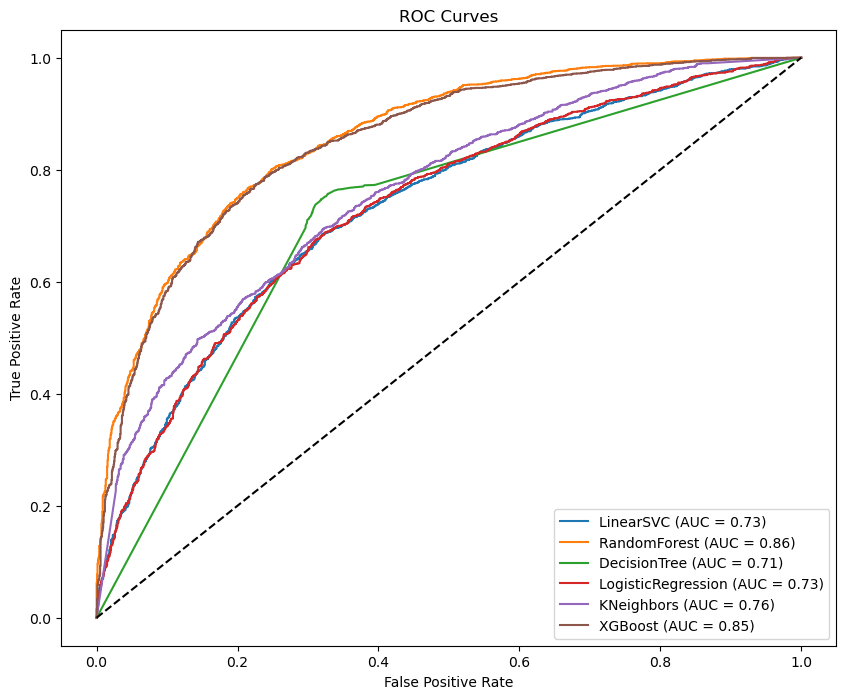

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0,1])

plt.figure(figsize=(10,8))

for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test_bin, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [46]:
from sklearn.model_selection import train_test_split

# Your full DataFrame with 'group' and 'target' columns

# Random split — groups not considered here, just normal split
train_df, test_df = train_test_split(fd_props, test_size=0.2, random_state=42)

# Keep groups separate for analysis later
groups_train = train_df['UniProt_ID'].reset_index(drop=True)
groups_test = test_df['UniProt_ID'].reset_index(drop=True)

# Prepare training features and labels (drop group)
X_train = train_df[feature_cols].reset_index(drop=True)
y_train = train_df['label'].reset_index(drop=True)

X_test = test_df[feature_cols].reset_index(drop=True)
y_test = test_df['label'].reset_index(drop=True)

# Train your model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Analysis per group:
import pandas as pd

results = pd.DataFrame({
    'group': groups_test,
    'y_true': y_test,
    'y_pred': y_pred
})

# Example: accuracy per group
accuracy_per_group = results.groupby('group').apply(lambda df: (df['y_true'] == df['y_pred']).mean())

print(accuracy_per_group)



group
O14757    0.705882
O43570    0.500000
O76074    0.750000
P00374    0.954545
P00520    1.000000
P00734    0.784247
P00742    0.807229
P00749    0.733333
P00811    0.600000
P00918    0.761120
P00929    0.000000
P02766    1.000000
P03176    1.000000
P03369    0.690141
P03372    0.793103
P03472    0.866667
P04035    0.588235
P04058    1.000000
P04150    0.666667
P04585    0.652174
P07342    0.000000
P07900    0.785992
P08709    0.750000
P10275    0.000000
P11086    1.000000
P15090    0.928571
P15121    0.774194
P15917    0.950000
P16083    0.777778
P20231    1.000000
P22906    0.800000
P24941    0.767123
P26281    0.918919
P27487    0.774194
P27707    0.846154
P28720    0.881356
P29476    0.770982
P35968    0.500000
P47811    0.166667
P49841    0.444444
P50097    1.000000
P50579    0.700000
P53779    0.600000
P55859    0.400000
P56658    0.692308
P9WIL5    0.666667
P9WKE1    0.500000
Q07343    0.666667
Q08499    0.636364
Q24451    0.700000
Q8I3X4    1.000000
Q9GPQ4    1.000000
dtype:

/tmp/ipykernel_56646/1491019052.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_per_group = results.groupby('group').apply(lambda df: (df['y_true'] == df['y_pred']).mean())


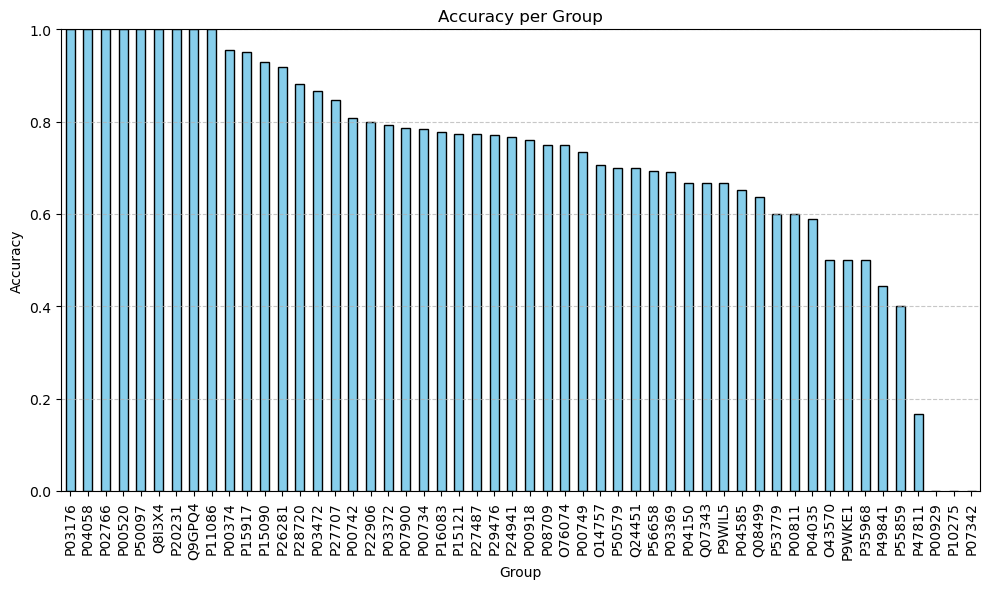

In [48]:
import matplotlib.pyplot as plt

# Sort values (optional, for better readability)
accuracy_per_group = accuracy_per_group.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
accuracy_per_group.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Accuracy per Group')
plt.xlabel('Group')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

,group,y_true,y_pred
0,P49841,1.0,0.0
1,P28720,0.0,0.0
2,P29476,0.0,0.0
3,P07900,1.0,1.0
4,P00918,1.0,0.0
...,...,...,...
3928,P29476,1.0,1.0
3929,P29476,1.0,1.0
3930,P15121,0.0,1.0
3931,O14757,0.0,1.0


In [51]:
from sklearn.metrics import precision_score, recall_score

precision_per_group = {}
recall_per_group = {}

for group, df_group in results.groupby('group'):
    y_true = df_group['y_true']
    y_pred = df_group['y_pred']
    
    # Set pos_label=0 to compute metrics for class 0
    precision = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
    
    precision_per_group[group] = precision
    recall_per_group[group] = recall


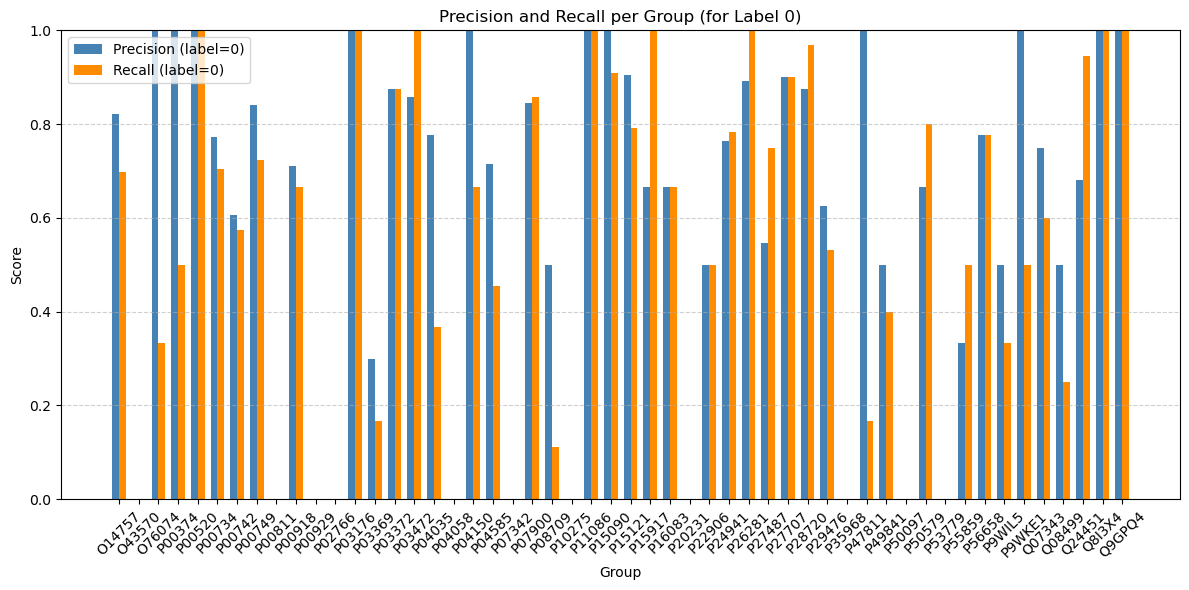

In [52]:
import matplotlib.pyplot as plt

# Convert to Series and sort (optional)
precision_series = pd.Series(precision_per_group).sort_index()
recall_series = pd.Series(recall_per_group).sort_index()

x = range(len(precision_series))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x, precision_series, width=width, label='Precision (label=0)', color='steelblue')
plt.bar([i + width for i in x], recall_series, width=width, label='Recall (label=0)', color='darkorange')

plt.xticks([i + width / 2 for i in x], precision_series.index, rotation=45)
plt.ylim(0, 1)
plt.xlabel('Group')
plt.ylabel('Score')
plt.title('Precision and Recall per Group (for Label 0)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [7]:
fd_props['stratify_key'] = fd_props['UniProt_ID'].astype(str) + '_' + fd_props['label'].astype(str)

# Initialize StratifiedKFold
n_splits = 10  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Features and target
X = fd_props[[
    "Template_Total_SASA",
    "Template_Polar_SASA",
    "Template_Apolar_SASA",
    "Docked_Total_SASA",
    "Docked_Polar_SASA",
    "Docked_Apolar_SASA",
    "Template_HeavyAtomCount",
    "Template_NHOHCount",
    "Template_NOCount",
    "Template_NumHAcceptors",
    "Template_NumHDonors",
    "Template_NumHeteroAtoms",
    "Template_NumRotatableBonds",
    "Template_RingSystemsCount",
    "Template_RingCount",
    "Template_NumAliphaticRings",
    "Template_NumAromaticRings",
    "Template_NumAliphaticHeterocycles",
    "Template_NumAromaticHeterocycles",
    "Docked_HeavyAtomCount",
    "Docked_NHOHCount",
    "Docked_NOCount",
    "Docked_NumHAcceptors",
    "Docked_NumHDonors",
    "Docked_NumHeteroAtoms",
    "Docked_NumRotatableBonds",
    "Docked_RingSystemsCount",
    "Docked_RingCount",
    "Docked_NumAliphaticRings",
    "Docked_NumAromaticRings",
    "Docked_NumAliphaticHeterocycles",
    "Docked_NumAromaticHeterocycles",
    "Template_MCS_HeavyAtomRatio",
    "Template_MCS_NHOH_Atoms",
    "Template_MCS_NO_Atoms",
    "Template_MCS_H_Acceptors",
    "Template_MCS_H_Donors",
    "Docked_MCS_HeavyAtomRatio",
    "Docked_MCS_NHOH_Atoms",
    "Docked_MCS_NO_Atoms",
    "Docked_MCS_H_Acceptors",
    "Docked_MCS_H_Donors",
    "ECTS_H_Donors",
    "FCTS_H_Donors",
    "MCS_SMARTS_Atoms_wildcards",
    "MCS_SMARTS_Bonds_wildcards"
                ]]

y = fd_props['label']  # Target variable
stratify_key = fd_props['stratify_key']  # Composite key for stratification

# Perform stratified splitting
for fold, (train_idx, test_idx) in enumerate(skf.split(X, stratify_key)):
    print(f"\nFold {fold + 1}")
    
    # Get train and test sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    group_train, group_test = fd_fil['UniProt_ID'].iloc[train_idx], fd_fil['UniProt_ID'].iloc[test_idx]
    
    # Verify class distribution
    print("Target distribution in train:", y_train.value_counts(normalize=True))
    print("Target distribution in test:", y_test.value_counts(normalize=True))
    
    # Verify group distribution
    print("Group distribution in train:", group_train.value_counts(normalize=True))
    print("Group distribution in test:", group_test.value_counts(normalize=True))


Fold 1


/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


NameError: name 'fd_fil' is not defined

In [34]:
skf

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Example dataset
# Assume df is your DataFrame with columns: features, 'target' (binary: 0/1), and 'group' (e.g., 'A', 'B', 'C')
np.random.seed(42)


# Create a composite stratification key
fd_fil['stratify_key'] = fd_fil['UniProt_ID'].astype(str) + '_' + fd_fil['label'].astype(str)

# Initialize StratifiedKFold
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Features and target
X = fd_fil[['Template', 'Ligand_ID']]  # Your features
y = fd_fil['label']  # Target variable
stratify_key = fd_fil['stratify_key']  # Composite key for stratification

# Perform stratified splitting
for fold, (train_idx, test_idx) in enumerate(skf.split(X, stratify_key)):
    print(f"\nFold {fold + 1}")
    
    # Get train and test sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    group_train, group_test = fd_fil['UniProt_ID'].iloc[train_idx], fd_fil['UniProt_ID'].iloc[test_idx]
    
    # Verify class distribution
    print("Target distribution in train:", y_train.value_counts(normalize=True))
    print("Target distribution in test:", y_test.value_counts(normalize=True))
    
    # Verify group distribution
    print("Group distribution in train:", group_train.value_counts(normalize=True))
    print("Group distribution in test:", group_test.value_counts(normalize=True))

/tmp/ipykernel_1445440/1065593939.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fd_fil['stratify_key'] = fd_fil['UniProt_ID'].astype(str) + '_' + fd_fil['label'].astype(str)
/scratch/software/miniconda3/envs/my-rdkit-env/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Fold 1
Target distribution in train: label
0.0    0.736398
1.0    0.263602
Name: proportion, dtype: float64
Target distribution in test: label
0.0    0.736224
1.0    0.263776
Name: proportion, dtype: float64
Group distribution in train: UniProt_ID
P00918    0.382912
P29476    0.207786
P07900    0.097291
P24941    0.084237
P00734    0.063421
            ...   
P35557    0.000020
P00183    0.000013
P10721    0.000013
Q07785    0.000013
P04818    0.000007
Name: proportion, Length: 72, dtype: float64
Group distribution in test: UniProt_ID
P00918    0.382927
P29476    0.207777
P07900    0.097276
P24941    0.084262
P00734    0.063414
            ...   
P10721    0.000026
P11712    0.000026
P35557    0.000026
P42260    0.000026
Q79MP6    0.000026
Name: proportion, Length: 67, dtype: float64

Fold 2
Target distribution in train: label
0.0    0.736384
1.0    0.263616
Name: proportion, dtype: float64
Target distribution in test: label
0.0    0.736276
1.0    0.263724
Name: proportion, dtype: flo

In [57]:
test_tbd = pd.read_csv('../data/template_based_docking_w_descriptors.csv')
test_tbd

,UniProt_ID,Template,Ligand_ID,Pose_ID,rmsd,MCS,Template_Total_SASA,Template_Polar_SASA,Template_Apolar_SASA,Docked_Total_SASA,...,Template_MCS_H_Donors,Docked_MCS_HeavyAtomRatio,Docked_MCS_NHOH_Atoms,Docked_MCS_NO_Atoms,Docked_MCS_H_Acceptors,Docked_MCS_H_Donors,ECTS_H_Donors,FCTS_H_Donors,MCS_SMARTS_Atoms_wildcards,MCS_SMARTS_Bonds_wildcards
0,O14757,1NVQ_UCN,1NVR_STU,6,0.538,[#6]-[#6]12-[#6](-[#6](-[#6]-[#6](-[#8]-1)-[#7...,615.802361,143.121824,472.680536,596.391678,...,2.0,1.000000,2.0,7.0,6.0,2.0,0.722222,0.860000,0.0,0.0
1,O14757,1NVQ_UCN,2BRM_DFZ,1,5.291,"[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-,:[#6](:[#6...",615.802361,143.121824,472.680536,489.053680,...,1.0,0.840000,2.0,2.0,1.0,2.0,0.123596,0.123288,0.0,4.0
2,O14757,1NVQ_UCN,2BRO_DF2,3,7.027,"[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-,:[#6](:[#6...",615.802361,143.121824,472.680536,544.687183,...,1.0,0.777778,2.0,2.0,1.0,2.0,0.129032,0.120000,0.0,4.0
3,O14757,1NVQ_UCN,2C3L_IDZ,1,6.612,"[#6](:[#6]:[#6]:[#6]):[#6]:[#6]:[#6](:[#7])-,:...",615.802361,143.121824,472.680536,400.822661,...,1.0,0.944444,1.0,3.0,2.0,1.0,0.108434,0.119403,0.0,3.0
4,O14757,1NVQ_UCN,2CGU_3A3,1,3.539,"[#6]1:[#6]:[#6](:[#6]:[#6]:[#6]:1)-,:[#6](:[#6...",615.802361,143.121824,472.680536,546.900001,...,1.0,0.560000,0.0,1.0,1.0,0.0,0.081395,0.136364,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155737,Q9GPQ4,3B9G_IMH,3EPX_IMQ,2,2.782,[#6]:[#6](:[#6](:[#6]:[#6]):[#7]:[#6])-[#6]-[#...,409.214112,261.120694,148.093418,432.402375,...,4.0,0.800000,3.0,5.0,5.0,3.0,0.187500,0.169492,0.0,0.0
155738,Q9GPQ4,3EPW_JMQ,3B9G_IMH,6,0.894,[#6]1:[#6](:[#6]2:[#6](:[#7]:1):[#6]:[#7]:[#6]...,429.223956,248.321560,180.902396,417.369533,...,5.0,0.947368,5.0,7.0,6.0,5.0,0.269841,0.309091,0.0,0.0
155739,Q9GPQ4,3EPX_IMQ,1HP0_AD3,1,0.564,"[#6](:[#6]:[#7]:[#6]:[#6]):,-[#6]:,-[#7]-[#6]-...",434.098839,142.812719,291.286120,408.535992,...,3.0,0.789474,3.0,5.0,5.0,3.0,0.238095,0.232143,0.0,2.0
155740,Q9GPQ4,3EPX_IMQ,3B9G_IMH,7,0.921,[#6]:[#6](:[#6](:[#6]:[#6]):[#7]:[#6])-[#6]-[#...,434.098839,142.812719,291.286120,415.035240,...,3.0,0.842105,4.0,5.0,5.0,4.0,0.187500,0.169492,0.0,0.0


In [58]:
mcs = test_tbd[test_tbd['Docked_MCS_HeavyAtomRatio'] >= 0.6]
mcs

,UniProt_ID,Template,Ligand_ID,Pose_ID,rmsd,MCS,Template_Total_SASA,Template_Polar_SASA,Template_Apolar_SASA,Docked_Total_SASA,...,Template_MCS_H_Donors,Docked_MCS_HeavyAtomRatio,Docked_MCS_NHOH_Atoms,Docked_MCS_NO_Atoms,Docked_MCS_H_Acceptors,Docked_MCS_H_Donors,ECTS_H_Donors,FCTS_H_Donors,MCS_SMARTS_Atoms_wildcards,MCS_SMARTS_Bonds_wildcards
0,O14757,1NVQ_UCN,1NVR_STU,6,0.538,[#6]-[#6]12-[#6](-[#6](-[#6]-[#6](-[#8]-1)-[#7...,615.802361,143.121824,472.680536,596.391678,...,2.0,1.000000,2.0,7.0,6.0,2.0,0.722222,0.860000,0.0,0.0
1,O14757,1NVQ_UCN,2BRM_DFZ,1,5.291,"[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-,:[#6](:[#6...",615.802361,143.121824,472.680536,489.053680,...,1.0,0.840000,2.0,2.0,1.0,2.0,0.123596,0.123288,0.0,4.0
2,O14757,1NVQ_UCN,2BRO_DF2,3,7.027,"[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-,:[#6](:[#6...",615.802361,143.121824,472.680536,544.687183,...,1.0,0.777778,2.0,2.0,1.0,2.0,0.129032,0.120000,0.0,4.0
3,O14757,1NVQ_UCN,2C3L_IDZ,1,6.612,"[#6](:[#6]:[#6]:[#6]):[#6]:[#6]:[#6](:[#7])-,:...",615.802361,143.121824,472.680536,400.822661,...,1.0,0.944444,1.0,3.0,2.0,1.0,0.108434,0.119403,0.0,3.0
5,O14757,1NVQ_UCN,2E9N_76A,3,12.230,"[#6](:[#6]:[#6](:[#6]:[#6])-,:[#6]:[#6](:,-[#6...",615.802361,143.121824,472.680536,707.063319,...,1.0,0.800000,3.0,3.0,1.0,3.0,0.116505,0.175000,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155737,Q9GPQ4,3B9G_IMH,3EPX_IMQ,2,2.782,[#6]:[#6](:[#6](:[#6]:[#6]):[#7]:[#6])-[#6]-[#...,409.214112,261.120694,148.093418,432.402375,...,4.0,0.800000,3.0,5.0,5.0,3.0,0.187500,0.169492,0.0,0.0
155738,Q9GPQ4,3EPW_JMQ,3B9G_IMH,6,0.894,[#6]1:[#6](:[#6]2:[#6](:[#7]:1):[#6]:[#7]:[#6]...,429.223956,248.321560,180.902396,417.369533,...,5.0,0.947368,5.0,7.0,6.0,5.0,0.269841,0.309091,0.0,0.0
155739,Q9GPQ4,3EPX_IMQ,1HP0_AD3,1,0.564,"[#6](:[#6]:[#7]:[#6]:[#6]):,-[#6]:,-[#7]-[#6]-...",434.098839,142.812719,291.286120,408.535992,...,3.0,0.789474,3.0,5.0,5.0,3.0,0.238095,0.232143,0.0,2.0
155740,Q9GPQ4,3EPX_IMQ,3B9G_IMH,7,0.921,[#6]:[#6](:[#6](:[#6]:[#6]):[#7]:[#6])-[#6]-[#...,434.098839,142.812719,291.286120,415.035240,...,3.0,0.842105,4.0,5.0,5.0,4.0,0.187500,0.169492,0.0,0.0


([<matplotlib.axis.XTick at 0x7540a17f5150>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19')])

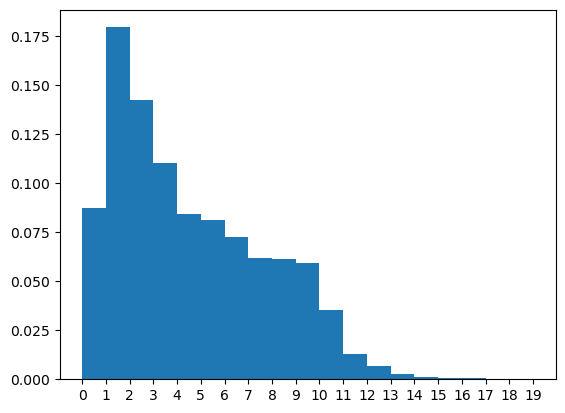

In [66]:
plt.hist(mcs['rmsd'], bins=range(0,20,1), density=True)
plt.xticks(range(0,20,1))

In [68]:
len(mcs[mcs.rmsd <= 2])/len(mcs)

0.26667676104914284